In [1]:
import csv
import pandas as pd
import torch
import numpy as np

In [8]:
!unzip -u '/content/drive/MyDrive/Assignment/Dataset_2.zip'

Archive:  /content/drive/MyDrive/Assignment/Dataset_2.zip
   creating: Dataset_2/
  inflating: Dataset_2/t10k-images-idx3-ubyte  
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
  inflating: Dataset_2/train-images-idx3-ubyte  
  inflating: Dataset_2/train-labels-idx1-ubyte  
  inflating: Dataset_2/verification_test.csv  
  inflating: Dataset_2/verification_train.csv  


In [9]:
train_csv2  = pd.read_csv('/content/Dataset_2/verification_train.csv')
test_csv2 = pd.read_csv('/content/Dataset_2/verification_test.csv')

In [10]:
train_csv2.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [11]:
test_csv2.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [12]:
import torch
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

In [13]:
class digit_Dataset(Dataset):
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.data_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.data_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [14]:
train_set = digit_Dataset(train_csv2, transform=transforms.Compose([transforms.ToTensor()]))
test_set = digit_Dataset(test_csv2, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=20)
test_loader = DataLoader(train_set, batch_size=20)

In [15]:
print(len(train_set))
print(len(test_set))

60000
10000


In [16]:
class Net(nn.Module): # Module is library package
    
    def __init__(self):
        super().__init__()
        
        self.fc1=nn.Linear(28*28, 200)  #flatten the image 
        self.fc2=nn.Linear(200,200)
        self.fc3=nn.Linear(200,200)
        self.fc4=nn.Linear(200,200)  
        self.fc5=nn.Linear(200,200)
        self.fc6=nn.Linear(200,10)
        
    def forward(self,x): # pass the data
        
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        x=f.relu(self.fc5(x))
        
        x=self.fc6(x)
        
        return x
               

net=Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=10, bias=True)
)


In [17]:
net.cuda()

Net(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=10, bias=True)
)

In [18]:
optimizer =  optim.SGD(net.parameters(), lr=0.01)
 
criterion = torch.nn.CrossEntropyLoss()

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cuda', index=0)

In [21]:
Path='./net_final.pth'
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 7
steps = 0
running_loss = 0
print_every = 500

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        net.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        
        logps = net.forward(inputs.view(-1,28*28))
        loss = criterion(logps, labels)
        loss.backward() 
        optimizer.step() 
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = net.forward(inputs.view(-1,28*28))
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            traininglosses.append(running_loss/print_every)
            trainingaccuracy.append(after_train_accuracy)
            testinglosses.append(test_loss/len(test_loader))
            testaccuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Steps {steps} "
                  f"Train Loss: {running_loss/print_every:f} "
                  f"Train Accuracy: {after_train_accuracy:f} "
                  f"Test Loss: {test_loss/len(test_loader):f} "
                  f"Test Accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            net.train()
print('Training finish')
torch.save(net.state_dict(), Path)

Device cuda:0 Epoch 1/7 Steps 500 Train Loss: 0.825886 Train Accuracy: 0.698900 Test Loss: 0.590405 Test Accuracy: 0.772302
Device cuda:0 Epoch 1/7 Steps 1000 Train Loss: 0.578722 Train Accuracy: 0.789700 Test Loss: 0.516582 Test Accuracy: 0.817151
Device cuda:0 Epoch 1/7 Steps 1500 Train Loss: 0.515919 Train Accuracy: 0.810100 Test Loss: 0.465960 Test Accuracy: 0.830952
Device cuda:0 Epoch 1/7 Steps 2000 Train Loss: 0.483479 Train Accuracy: 0.822000 Test Loss: 0.428924 Test Accuracy: 0.846351
Device cuda:0 Epoch 1/7 Steps 2500 Train Loss: 0.465619 Train Accuracy: 0.832200 Test Loss: 0.434494 Test Accuracy: 0.838718
Device cuda:0 Epoch 1/7 Steps 3000 Train Loss: 0.452052 Train Accuracy: 0.834800 Test Loss: 0.433584 Test Accuracy: 0.838434
Device cuda:0 Epoch 2/7 Steps 3500 Train Loss: 0.412067 Train Accuracy: 0.846800 Test Loss: 0.391825 Test Accuracy: 0.853950
Device cuda:0 Epoch 2/7 Steps 4000 Train Loss: 0.413938 Train Accuracy: 0.846600 Test Loss: 0.406458 Test Accuracy: 0.853884
D

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


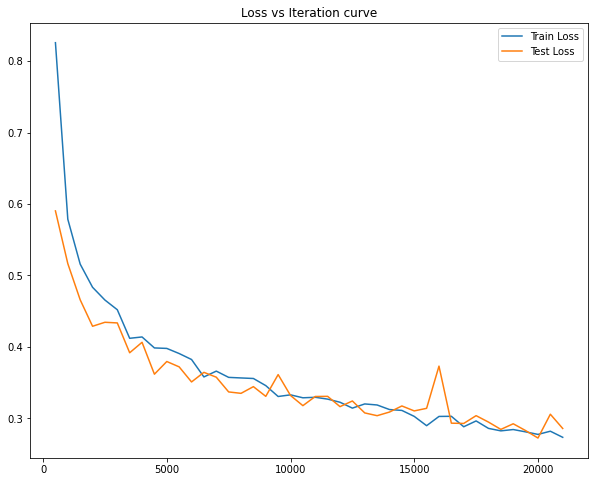

In [22]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
ax.set_title('Loss vs Iteration curve')
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.legend()
plt.show()

In [23]:
correct=0
total=0
with torch.no_grad():
    for data in test_loader:
        X,y=data
        X, y = X.to(device), y.to(device)
        
        output=net(X.view(-1,28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i)==y[idx]:
                correct+=1
            total+=1
            
print(round(correct/total,3))

0.893


In [24]:
correct

53604

In [26]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net.forward(inputs.view(-1,28*28))
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[5.0030e+03, 0.0000e+00, 5.0000e+01, 4.9000e+01, 1.7000e+01, 2.0000e+00,
         8.6200e+02, 0.0000e+00, 1.7000e+01, 0.0000e+00],
        [5.2000e+01, 5.7370e+03, 3.0000e+00, 1.4700e+02, 2.2000e+01, 0.0000e+00,
         3.4000e+01, 0.0000e+00, 5.0000e+00, 0.0000e+00],
        [7.5000e+01, 0.0000e+00, 4.6810e+03, 7.2000e+01, 6.3400e+02, 1.0000e+00,
         5.2900e+02, 0.0000e+00, 8.0000e+00, 0.0000e+00],
        [3.3800e+02, 4.0000e+00, 9.0000e+00, 5.3790e+03, 9.2000e+01, 4.0000e+00,
         1.6000e+02, 0.0000e+00, 1.4000e+01, 0.0000e+00],
        [5.0000e+00, 1.0000e+00, 3.1900e+02, 4.3100e+02, 4.7190e+03, 1.0000e+00,
         5.0900e+02, 0.0000e+00, 1.5000e+01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9250e+03,
         0.0000e+00, 6.2000e+01, 0.0000e+00, 1.3000e+01],
        [5.5200e+02, 3.0000e+00, 3.2500e+02, 1.0800e+02, 3.2200e+02, 1.0000e+00,
         4.6650e+03, 0.0000e+00, 2.3000e+01, 1.0000e+00],
        [0.0000e+00, 0.0000

Text(0.5, 51.0, 'Predicted label')

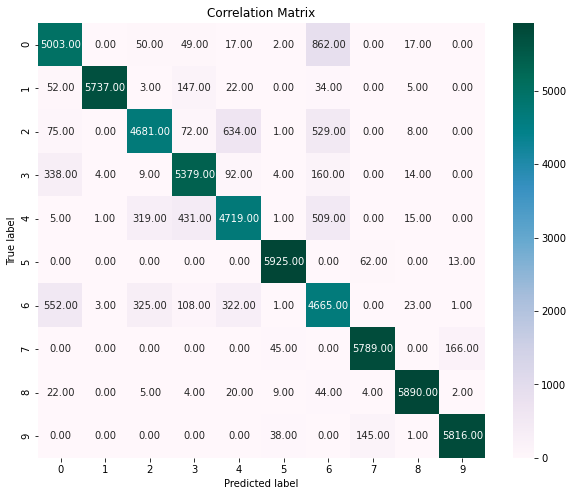

In [27]:
import pandas as pd
import seaborn as sns
class_names = ["0","1","2","3","4","5","6","7","8","9"]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
f, ax = plt.subplots(figsize= [10,8])
sns.heatmap(df_cm, annot=True, fmt=".2f", ax=ax, cmap = "PuBuGn" )
ax.set_title("Correlation Matrix", fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [82]:
train_set = digit_Dataset(train_csv2, transform=transforms.Compose([transforms.ToTensor()]))
test_set = digit_Dataset(test_csv2, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [83]:
print(len(train_set))
print(len(test_set))

60000
10000


In [94]:
class Net(nn.Module): # Module is library package
    
    def __init__(self):
        super().__init__()
        
        self.fc1=nn.Linear(28*28, 1000)  #flatten the image 
        self.fc2=nn.Linear(1000,1000)
        self.fc3=nn.Linear(1000,1000)
        self.fc4=nn.Linear(1000,1000)  
        self.fc5=nn.Linear(1000,1000)
        self.fc6=nn.Linear(1000,10)
        
    def forward(self,x): # pass the data
        
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        x=f.relu(self.fc5(x))
        
        x=self.fc6(x)
        
        return x
               

net=Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=1000, bias=True)
  (fc6): Linear(in_features=1000, out_features=10, bias=True)
)


In [95]:
net.cuda()

Net(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=1000, bias=True)
  (fc6): Linear(in_features=1000, out_features=10, bias=True)
)

In [96]:
optimizer =  optim.SGD(net.parameters(), lr=0.01)
 
criterion = torch.nn.CrossEntropyLoss()

In [97]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [98]:
device

device(type='cuda', index=0)

In [99]:
Path='./net_final.pth'
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 84
steps = 0
running_loss = 0
print_every = 500

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        net.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        
        logps = net.forward(inputs.view(-1,28*28))
        loss = criterion(logps, labels)
        loss.backward() 
        optimizer.step() 
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = net.forward(inputs.view(-1,28*28))
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            traininglosses.append(running_loss/print_every)
            trainingaccuracy.append(after_train_accuracy)
            testinglosses.append(test_loss/len(test_loader))
            testaccuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Steps {steps} "
                  f"Train Loss: {running_loss/print_every:f} "
                  f"Train Accuracy: {after_train_accuracy:f} "
                  f"Test Loss: {test_loss/len(test_loader):f} "
                  f"Test Accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            net.train()
print('Training finish')
torch.save(net.state_dict(), Path)

Device cuda:0 Epoch 1/84 Steps 500 Train Loss: 0.586843 Train Accuracy: 0.793320 Test Loss: 0.428728 Test Accuracy: 0.843000
Device cuda:0 Epoch 2/84 Steps 1000 Train Loss: 0.396678 Train Accuracy: 0.686200 Test Loss: 0.341473 Test Accuracy: 0.875100
Device cuda:0 Epoch 3/84 Steps 1500 Train Loss: 0.347774 Train Accuracy: 0.526620 Test Loss: 0.301646 Test Accuracy: 0.889368
Device cuda:0 Epoch 4/84 Steps 2000 Train Loss: 0.312567 Train Accuracy: 0.355220 Test Loss: 0.291941 Test Accuracy: 0.890701
Device cuda:0 Epoch 5/84 Steps 2500 Train Loss: 0.286905 Train Accuracy: 0.179760 Test Loss: 0.285744 Test Accuracy: 0.892784
Device cuda:0 Epoch 5/84 Steps 3000 Train Loss: 0.265737 Train Accuracy: 0.902000 Test Loss: 0.249640 Test Accuracy: 0.907318
Device cuda:0 Epoch 6/84 Steps 3500 Train Loss: 0.242830 Train Accuracy: 0.910341 Test Loss: 0.262910 Test Accuracy: 0.900801
Device cuda:0 Epoch 7/84 Steps 4000 Train Loss: 0.225118 Train Accuracy: 0.734920 Test Loss: 0.217824 Test Accuracy: 0.

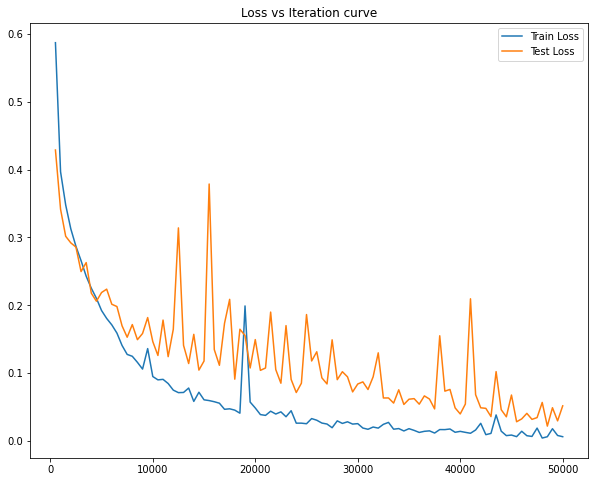

In [100]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
ax.set_title('Loss vs Iteration curve')
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.legend()
plt.show()

In [101]:
correct=0
total=0
with torch.no_grad():
    for data in test_loader:
        X,y=data
        X, y = X.to(device), y.to(device)
        
        output=net(X.view(-1,28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i)==y[idx]:
                correct+=1
            total+=1
            
print(round(correct/total,3))

0.988


In [102]:
correct

59299

In [104]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net.forward(inputs.view(-1,40*40))
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 509.,  128.,  138.,  217.,   15.,  330.,  207.,  119., 1005.,  265.],
        [ 480.,  160.,  154.,  260.,   18.,  331.,  176.,  106.,  990.,  275.],
        [ 469.,  116.,  186.,  244.,   14.,  310.,  161.,  120., 1009.,  274.],
        [ 489.,  113.,  142.,  286.,   23.,  358.,  177.,  119.,  958.,  277.],
        [ 504.,  108.,  127.,  218.,   80.,  305.,  161.,  111., 1004.,  285.],
        [ 478.,  120.,  145.,  237.,   15.,  384.,  170.,  109., 1045.,  275.],
        [ 490.,  116.,  176.,  219.,   15.,  306.,  249.,  107., 1040.,  266.],
        [ 444.,  116.,  166.,  214.,   22.,  295.,  182.,  180., 1058.,  286.],
        [ 460.,  101.,  132.,  204.,   23.,  324.,  184.,   96., 1111.,  260.],
        [ 492.,  100.,  186.,  237.,   12.,  287.,  170.,  112., 1028.,  325.]])


Text(0.5, 51.0, 'Predicted label')

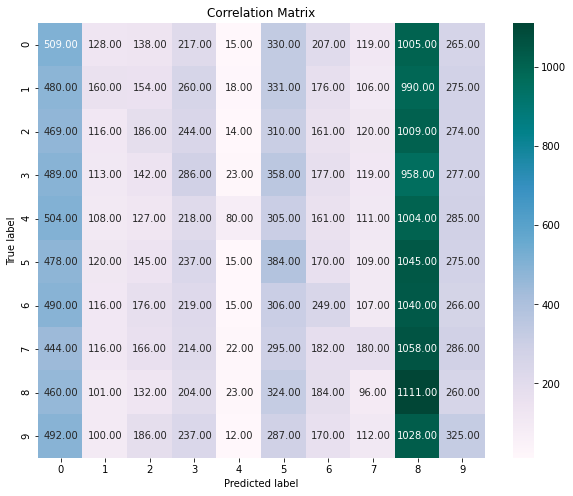

In [105]:
import pandas as pd
import seaborn as sns
class_names = ["0","1","2","3","4","5","6","7","8","9"]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
f, ax = plt.subplots(figsize= [10,8])
sns.heatmap(df_cm, annot=True, fmt=".2f", ax=ax, cmap = "PuBuGn" )
ax.set_title("Correlation Matrix", fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')